importing important libraries

In [1]:

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm
import cv2
import os
import shutil
import itertools  
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from google.colab import drive

In [3]:

os.getcwd()

'/content'

In [4]:
cov_Dir ='/content/drive/MyDrive/COVID_IEEE/covid'
norm_Dir ='/content/drive/MyDrive/COVID_IEEE/normal'
vir_Dir ='/content/drive/MyDrive/COVID_IEEE/virus'

In [5]:

def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

In [6]:
# function for getting image specification details
def Images_details(path):
    files = [f for f  in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  
    data['max_width'] = 0
    data['min_height'] = 10**100  
    data['max_height'] = 0

    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])
    Images_details_Print_data(data, path)



In [7]:

Images_details(norm_Dir)


 ====== Images in:  /content/drive/MyDrive/COVID_IEEE/normal
images_count:	668
min_width:	1040
max_width:	2628
min_height:	650
max_height:	2628


In [8]:

Images_details(cov_Dir)


 ====== Images in:  /content/drive/MyDrive/COVID_IEEE/covid
images_count:	534
min_width:	240
max_width:	4095
min_height:	237
max_height:	4095


In [9]:

Images_details(vir_Dir)

 ====== Images in:  /content/drive/MyDrive/COVID_IEEE/virus
images_count:	619
min_width:	384
max_width:	2304
min_height:	127
max_height:	2304


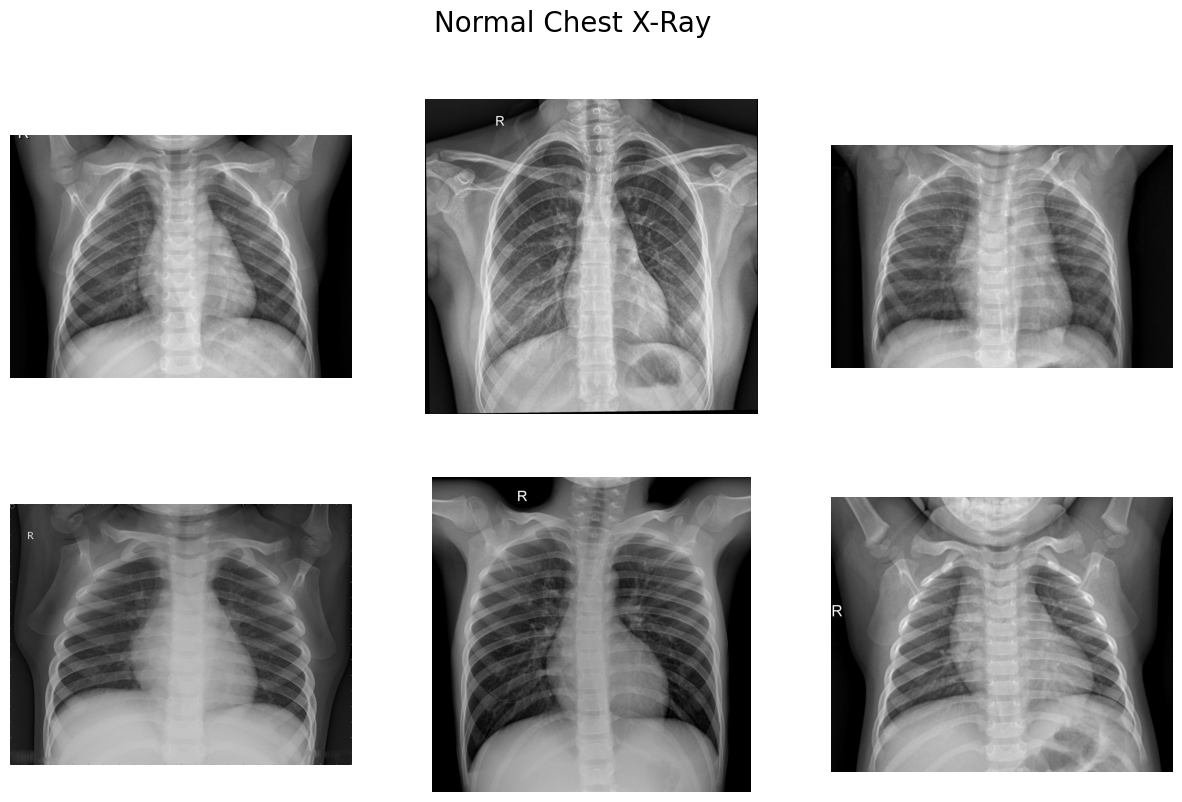

In [10]:

norm_images = os.listdir(norm_Dir)
sample_images = random.sample(norm_images,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    im = cv2.imread('/content/drive/My Drive/COVID_IEEE/normal/'+sample_images[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Chest X-Ray',fontsize=20)
plt.show()

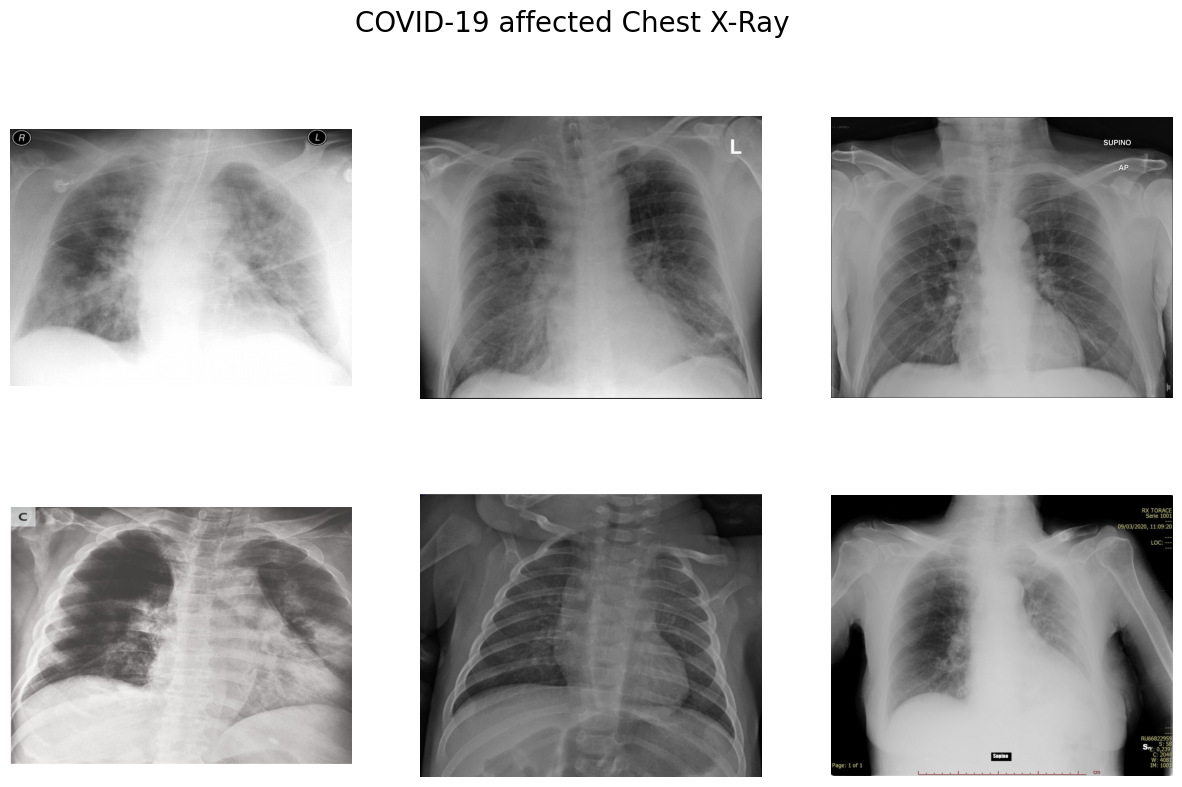

In [11]:

Cov_images = os.listdir(cov_Dir)
sample_images = random.sample(Cov_images,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    im = cv2.imread('/content/drive/My Drive/COVID_IEEE/covid/'+sample_images[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('COVID-19 affected Chest X-Ray',fontsize=20)
plt.show()

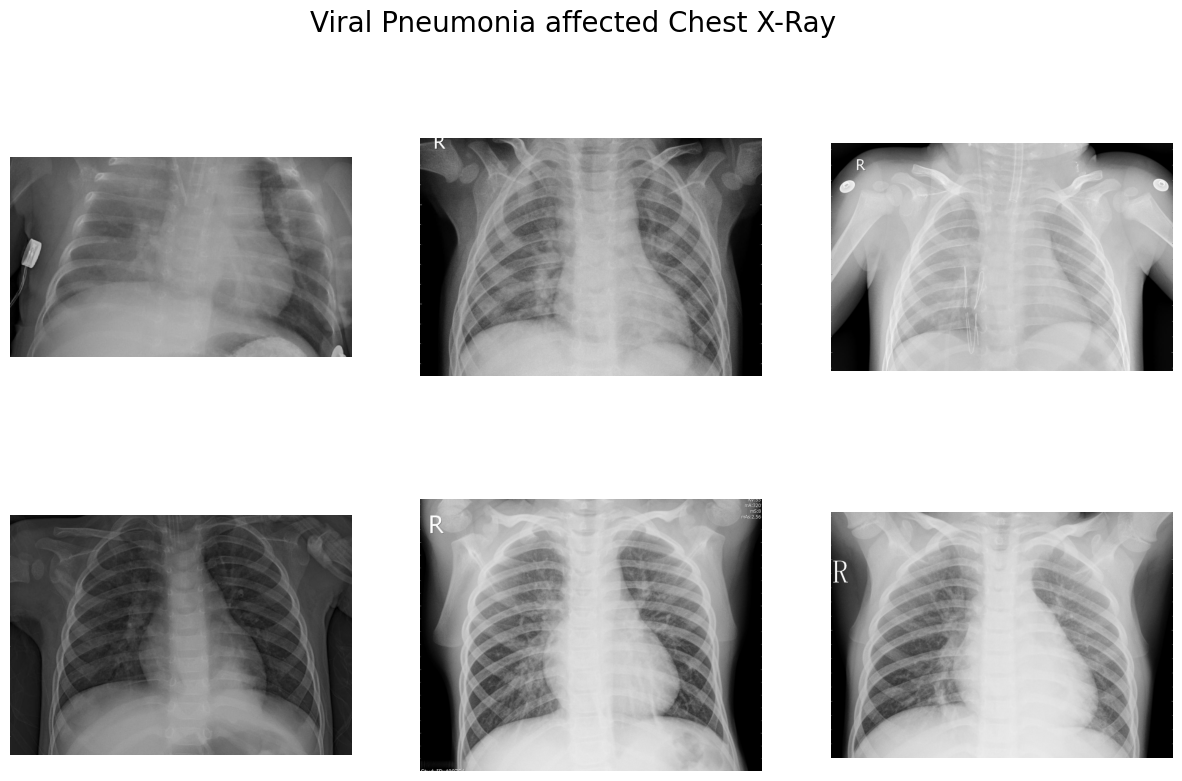

In [12]:

vir_images = os.listdir(vir_Dir)
sample_vimages = random.sample(vir_images,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    im = cv2.imread('/content/drive/My Drive/COVID_IEEE/virus/'+sample_vimages[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Viral Pneumonia affected Chest X-Ray',fontsize=20)
plt.show()

In [13]:
#3. Data Loading & Image pre-processing

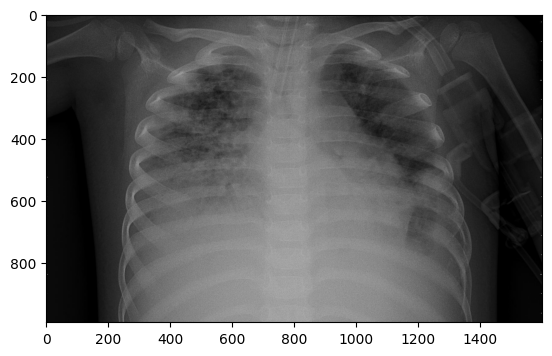

In [14]:
# Loading Original viral Image sample images 
img = cv2.imread('/content/drive/My Drive/COVID_IEEE/virus/person1661_virus_2872.jpeg')
plt.imshow(img, cmap=plt.cm.bone)

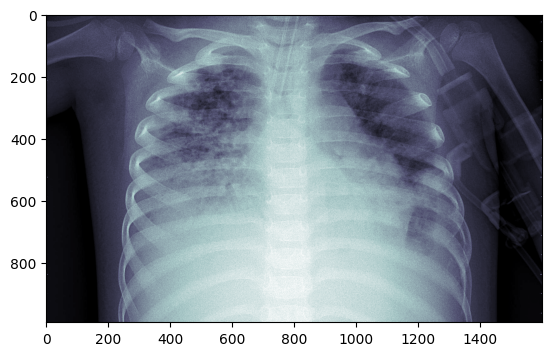

In [15]:

def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)] )
gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap=plt.cm.bone)

Loading data and pre-processing images using white balance on the both folders

In [16]:
data=[]
labels=[]
Normal=os.listdir("/content/drive/My Drive/COVID_IEEE/normal/")
for a in Normal:
    image = cv2.imread("/content/drive/My Drive/COVID_IEEE/normal/"+a)
    # our performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data.append(image)
    labels.append(0)

Covid=os.listdir("/content/drive/My Drive/COVID_IEEE/covid/")
for b in Covid:
    image = cv2.imread("/content/drive/My Drive/COVID_IEEE/covid/"+b)
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data.append(image)
    labels.append(1)
 
Virus=os.listdir("/content/drive/My Drive/COVID_IEEE/virus/")
for c in Virus:
    image = cv2.imread("/content/drive/My Drive/COVID_IEEE/virus/"+c)
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data.append(image)
    labels.append(2)

CONVERTING THE IMAGES INTO NUMPY ARRAYS

In [17]:

feats=np.array(data)
labels=np.array(labels)

#now here iam saving features and labels for later re-use
np.save("/content/drive/My Drive/COVID_IEEE/feats_train",feats)
np.save("/content/drive/My Drive/COVID_IEEE/labels_train",labels)

In [18]:

feats=np.load("/content/drive/My Drive/COVID_IEEE/feats_train.npy")
labels=np.load("/content/drive/My Drive/COVID_IEEE/labels_train.npy")

s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

1821


DIVIDE THE DATASET UNTO TRAIN TEST SPLIT

In [19]:

(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]
(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [20]:
from keras.utils import to_categorical

In [21]:
 
x_train = x_train.astype('float32')/255 
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

image **augementaion**

In [22]:
trainAug  = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    fill_mode="nearest")

model bulding

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')
for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 1s 0us/step


In [24]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LROnPlateau(monitor='val_loss', factor=0.3, 
    patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [26]:

BS = 16
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(x_train,y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=50,callbacks=callbacks)

[INFO] training head...
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.9832 - accuracy: 0.5802
Epoch 1: val_loss improved from inf to 12.50053, saving model to .mdl_wts_mobilenetv2.hdf5
91/91 [==============================] - 78s 261ms/step - loss: 0.9832 - accuracy: 0.5802 - val_loss: 12.5005 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.8071
Epoch 2: val_loss improved from 12.50053 to 8.86507, saving model to .mdl_wts_mobilenetv2.hdf5
91/91 [==============================] - 22s 240ms/step - loss: 0.6954 - accuracy: 0.8071 - val_loss: 8.8651 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.8501
Epoch 3: val_loss did not improve from 8.86507
91/91 [==============================] - 20s 212ms/step - loss: 0.5158 - accuracy: 0.8501 - val_loss: 20.8529 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 4/50
91/91 [======

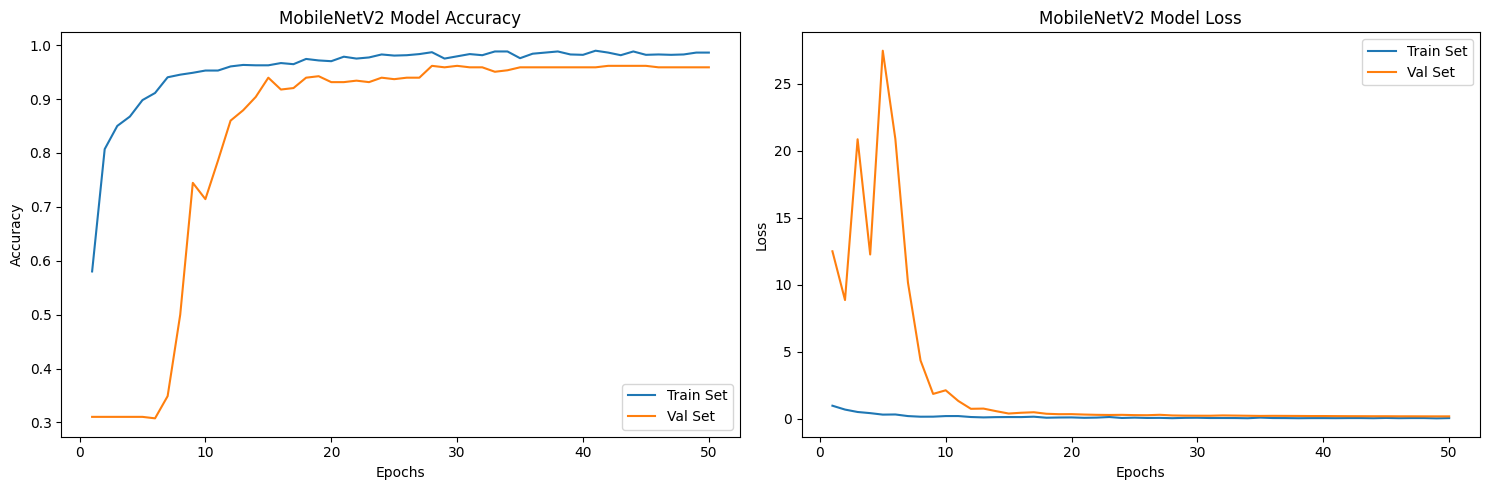

In [27]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs_range = range(1, len(H.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')

plt.tight_layout()
plt.show()

Evaluation of accuracy and performance of the model

In [28]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/COVID PROJECT /covid_model/mobilenet.h5')
model= load_model('/content/drive/MyDrive/COVID PROJECT /covid_model/mobilenet.h5')
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

12/12 [==============================] - 3s 81ms/step - loss: 0.1884 - accuracy: 0.9588

 Test_Accuracy:- 0.958791196346283


confusion MATRIX

23/23 [==============================] - 1s 22ms/step


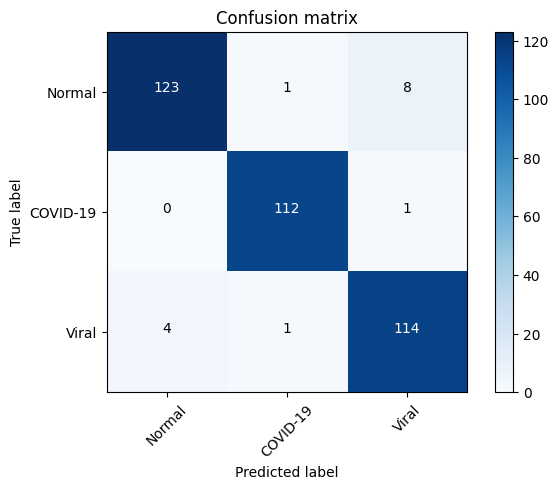

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','COVID-19','Viral']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
Y_pred_classes = np.argmax(pred_Y,axis=1) 
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

CLASSIFICATIN REPORT

In [30]:
print("Shape of x_train:", x_train.shape)  
print("Shape of y_test:", y_test.shape)    


Shape of x_train: (1457, 224, 224, 3)
Shape of y_test: (364, 3)


23/23 [==============================] - 1s 23ms/step


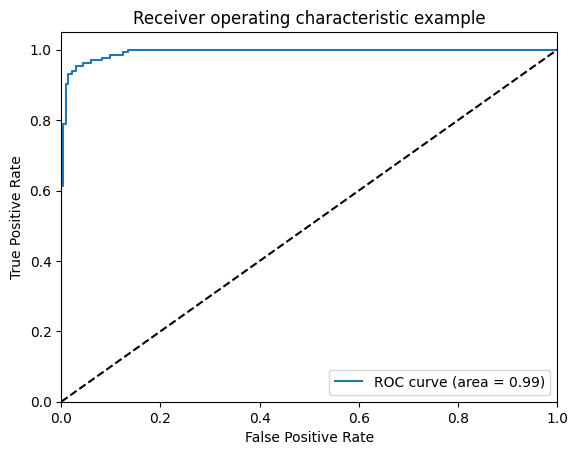

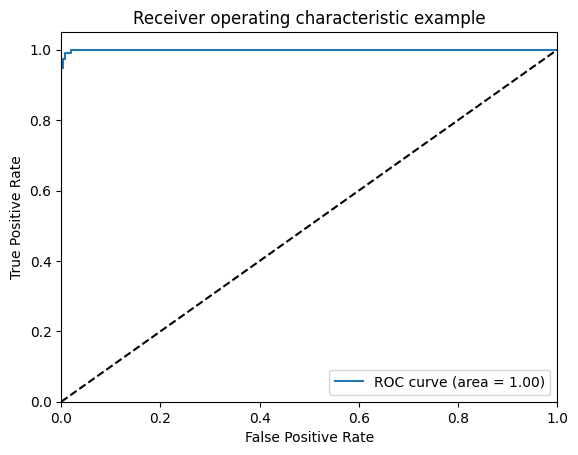

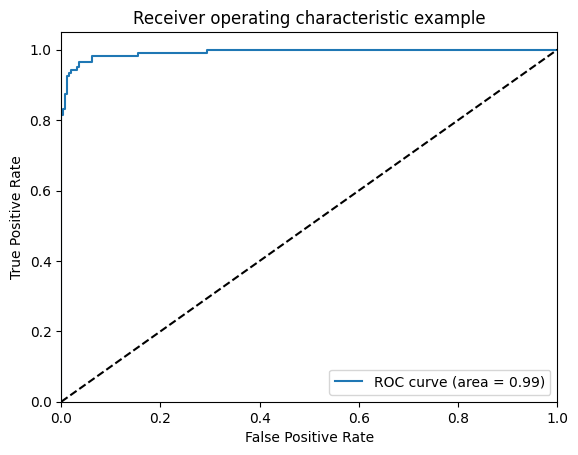

In [35]:
#dependencies for pltting ROC curve  
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_test = np.array(y_test)
n_classes = 3

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

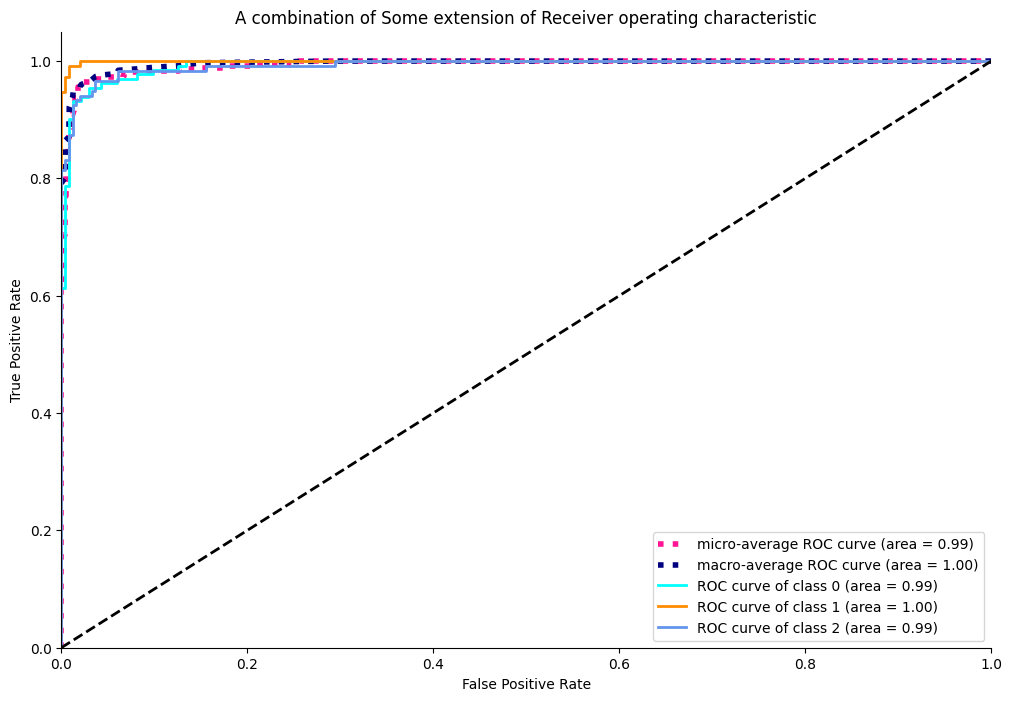

In [36]:
# Plot com ine cuves all ROC curves 
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('A combination of Some extension of Receiver operating characteristic')
plt.legend(loc="lower right")
sns.despine()
plt.show()